In [18]:
# Imports
%pylab inline

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.distributions import Normal, Laplace, Independent, Bernoulli, Gamma, Uniform, Beta
from torch.distributions.kl import kl_divergence

Populating the interactive namespace from numpy and matplotlib


In [19]:
# Load the MNIST training and test sets

def load_data(batch_size):
    train_data = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size, shuffle=True, **{})

    test_data = datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})
    return train_data, train_loader, test_data, test_loader

In [20]:
# Distribution namespaces

def normal_dist(mu, var):
    return Normal(loc=mu, scale=var)

def laplace_dist(mu, var):
    return Laplace(loc=mu, scale=var)

def gamma_dist(mu, var):
    return Gamma(concentration=mu, rate=var)

def beta_dist(mu, var):
    return Beta(concentration1=mu, concentration0=var)

def bernoulli_loss(x_hat):
    return Bernoulli(x_hat)

def laplace_loss(x_hat, scale=0.01):
    return Laplace(loc=x_hat, scale=scale)

In [21]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)


class VAE(nn.Module):
    def __init__(self, conv_encoder, linear_encoder, linear_decoder, conv_decoder, loss_dist, p_x_dist, q_z_dist):
        super(VAE, self).__init__()
        self.conv_encoder = nn.Sequential(*conv_encoder)
        self.linear_encoder = nn.Sequential(*linear_encoder)
        self.linear_decoder = nn.Sequential(*linear_decoder)
        self.conv_decoder = nn.Sequential(*conv_decoder)
        self.p_x_dist = p_x_dist
        self.q_z_dist = q_z_dist
        self.loss_dist = loss_dist

    def encode(self, x):
        # First go through the convolutional layers
        output = self.conv_encoder(x)
        # Flatten the output (TODO: make 4*4*50 a variable that comes from the convolutional layers)
        output = output.view(-1, 4*4*50)
        # Go through the linear layers
        output = self.linear_encoder(output)
        output_len = len(output[0]) // 2
        return output[:,:output_len], output[:,output_len:]

    def reparameterize(self, q_z):
        return q_z.rsample()

    def decode(self, z):
        z = self.linear_decoder(z).view(z.size(0), 50, 4, 4)
        return self.conv_decoder(z)

    def forward(self, x, epoch):
        mu, logvar = self.encode(x)
        
        q_z = self.q_z_dist(mu, logvar)
        q_z = Independent(q_z, 1)
        
        z = self.reparameterize(q_z)
        x_hat = self.decode(z).view(-1, x_dim)
        
        p_x = self.loss_dist(x_hat)
        loss = self.loss_function(x_hat, x, p_x, q_z, z, epoch)
        
        return x_hat, loss, z
    
    def loss_function(self, x_hat, x, p_x, q_z, z, epoch):
        x = x.view(-1, x_dim)
        BCE = torch.sum(-p_x.log_prob(x))
        KLD = kl_divergence(q_z.base_dist, self.p_x_dist.base_dist)
        KLD = torch.sum(KLD.sum(len(p_x_dist.event_shape)-1))
        
        if epoch<one_third_epochs:
            beta = epoch*max_beta/one_third_epochs

        else:
            beta = max_beta
        
        return BCE + beta*KLD

In [22]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        x_hat, loss, _ = model(data, epoch)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, batch_size):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data
            x_hat, loss, _ = model(data, epoch)
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      x_hat.view(batch_size, 1, 28, 28)[:n]])

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [23]:
x_dim = 784
z_dim = 20

lr = 1e-3 # Learning rate
batch_size = 64
epochs = 3
max_beta = 3
one_third_epochs = round(epochs/3)


# Prior distribution
tensor = torch.ones(1)
p_x_dist = Beta(tensor.new_full((1, 20), 0.5), tensor.new_full((1, 20), 0.5))
p_x_dist = Independent(p_x_dist, 1)

# Target distribution
q_z_dist = beta_dist

# Loss distribution
loss_dist = bernoulli_loss

conv_encoder_layers = [
    nn.Conv2d(1, 20, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2)
    ]

linear_encoder_layers = [
    nn.Linear(50*4*4, 392),
    nn.ReLU(True),
    nn.Linear(392, 196),
    nn.ReLU(True),
    nn.Linear(196, 49),
    nn.ReLU(True),
    nn.Linear(49, z_dim*2),
    nn.Softplus()
    ]

linear_decoder_layers = [
    nn.Linear(z_dim, 49),
    nn.ReLU(True),
    nn.Linear(49, 196),
    nn.ReLU(True),
    nn.Linear(196, 392),
    nn.ReLU(True),
    nn.Linear(392, 50*4*4),
    nn.Sigmoid()
    ]

conv_decoder_layers = [
    nn.ConvTranspose2d(50, 20, 5, 1),
    nn.ReLU(True),
    nn.Upsample(scale_factor=3),
    nn.ConvTranspose2d(20, 1, 5, 1),
    nn.ReLU(True)
    ]

# Load the MNIST data
train_data, train_loader, test_data, test_loader = load_data(batch_size)

# Create the model
model = VAE(conv_encoder=conv_encoder_layers, linear_encoder=linear_encoder_layers,
            linear_decoder=linear_decoder_layers, conv_decoder=conv_decoder_layers, p_x_dist=p_x_dist, q_z_dist=q_z_dist, loss_dist=loss_dist)

optimizer = optim.Adam(model.parameters(), lr=lr)

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch, batch_size)
        # collection_image(epoch)        


0it [00:00, ?it/s]


 65%|██████▍   | 6422528/9912422 [00:40<00:33, 102825.39it/s]


100%|█████████▉| 9912320/9912422 [01:04<00:00, 232744.73it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz




0it [00:00, ?it/s]



  0%|          | 0/28881 [00:00<?, ?it/s]

 28%|██▊       | 8192/28881 [00:00<00:00, 79469.29it/s]

32768it [00:00, 67658.76it/s]                          

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz




  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:11, 143085.98it/s]

  2%|▏         | 32768/1648877 [00:00<00:11, 146462.45it/s]

  3%|▎         | 57344/1648877 [00:00<00:10, 153589.56it/s]

  5%|▍         | 81920/1648877 [00:00<00:09, 157936.31it/s]

  6%|▋         | 106496/1648877 [00:00<00:09, 156125.51it/s]

  8%|▊         | 131072/1648877 [00:01<00:09, 166450.01it/s]

  9%|▉         | 155648/1648877 [00:01<00:08, 183763.59it/s]

 11%|█         | 180224/1648877 [00:01<00:07, 195790.96it/s]

 13%|█▎        | 212992/1648877 [00:01<00:07, 199982.91it/s]

 14%|█▍        | 237568/1648877 [00:01<00:08, 171156.04it/s]

 17%|█▋        | 278528/1648877 [00:01<00:06, 201419.63it/s]

 18%|█▊        | 303104/1648877 [00:01<00:06, 192629.57it/s]

 20%|█▉        | 327680/1648877 [00:01<00:07, 184307.89it/s]

 21%|██▏       | 352256/1648877 [00:02<00:07, 175815.97it/s]

 23%|██▎       | 376832/1648877 [00:02<00:07, 167156.51it/s]

 24%|██▍       | 401408/164

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz





  0%|          | 0/4542 [00:00<?, ?it/s]


8192it [00:00, 40521.24it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/home/tim/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Train Epoch: 1 [0/60000 (0%)]	Loss: 1132.504150



9920512it [01:19, 232744.73it/s]                             

1654784it [00:24, 180013.37it/s]                             

Train Epoch: 1 [6400/60000 (11%)]	Loss: 247.396545
Train Epoch: 1 [12800/60000 (21%)]	Loss: 234.494522
Train Epoch: 1 [19200/60000 (32%)]	Loss: 232.700180
Train Epoch: 1 [25600/60000 (43%)]	Loss: 222.154053
Train Epoch: 1 [32000/60000 (53%)]	Loss: 228.800262
Train Epoch: 1 [38400/60000 (64%)]	Loss: 221.403687
Train Epoch: 1 [44800/60000 (75%)]	Loss: 238.445145
Train Epoch: 1 [51200/60000 (85%)]	Loss: 230.195984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 253.594742
====> Epoch: 1 Average loss: 239.8007
====> Test set loss: 235.0657
Train Epoch: 2 [0/60000 (0%)]	Loss: 225.391251
Train Epoch: 2 [6400/60000 (11%)]	Loss: 219.955246
Train Epoch: 2 [12800/60000 (21%)]	Loss: 222.399231
Train Epoch: 2 [19200/60000 (32%)]	Loss: 214.179916
Train Epoch: 2 [25600/60000 (43%)]	Loss: 226.211609
Train Epoch: 2 [32000/60000 (53%)]	Loss: 218.646317
Train Epoch: 2 [38400/60000 (64%)]	Loss: 209.756790
Train Epoch: 2 [44800/60000 (75%)]	Loss: 227.663284
Train Epoch: 2 [51200/60000 (85%)]	Loss: 228.431015
Tra

/home/tim/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


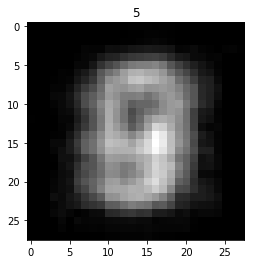

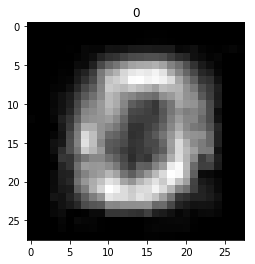

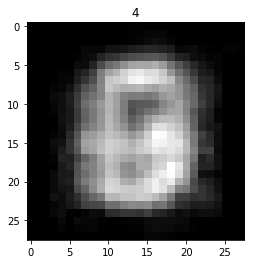

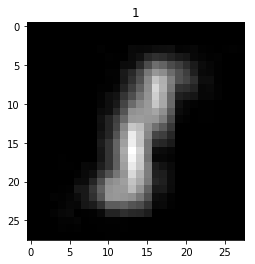

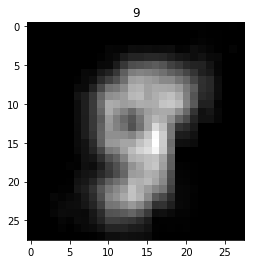

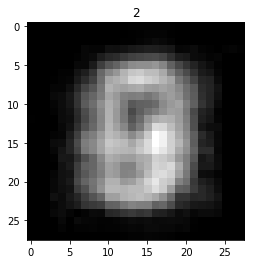

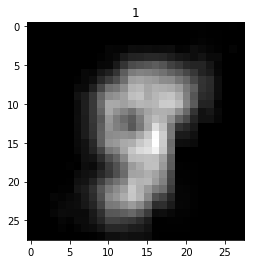

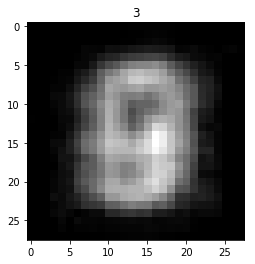

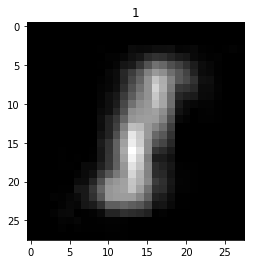

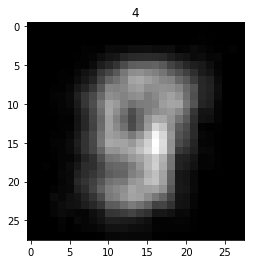

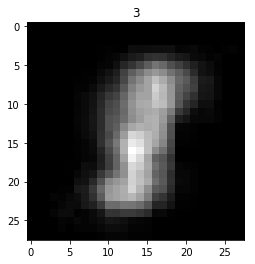

In [24]:
### Let's check if the reconstructions make sense
# Set model to test mode
model.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, _ = model(data, 1)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 10:
        break


In [25]:
from torchvision.utils import save_image

xv = np.arange(0, 1, .04)
yv = np.arange(0, 1, .04)
sample = np.zeros([len(yv)*len(xv), 2])
counter = 0
for i, j in zip(xv, yv):
    for j in yv:
        sample[counter] = [i, j]
        counter += 1

images = model.decode(torch.tensor(sample, dtype=torch.float)).detach().numpy()
image = np.zeros([len(xv)*28, len(yv)*28])
counter = 0
for i in range(len(xv)):
    for j in range(len(yv)):
        image[i*28:i*28+28,j*28:j*28+28] = images[counter].reshape((28,28))
        counter += 1

plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')

RuntimeError: size mismatch, m1: [625 x 2], m2: [20 x 49] at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THTensorMath.cpp:940

/home/tim/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


0
127
97
109
105
82
0
0
0
0
6.679561376571655


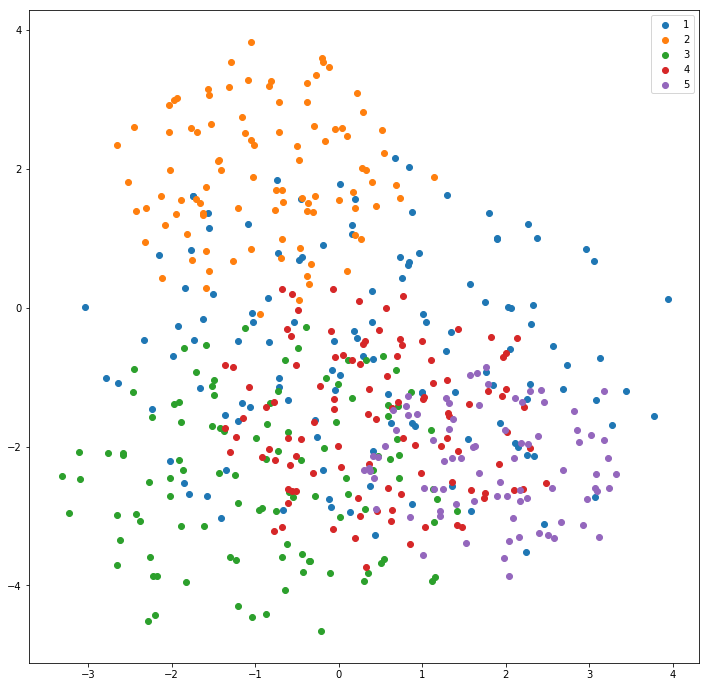

In [52]:
from sklearn.manifold import TSNE
import time

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=True, **{})

z_dims = [[] for i in range(10)]
x_dims = [[] for i in range(10)]
start = time.time()
check_digits = [1, 2, 3, 4, 5]

for batch_idx, (data, label) in enumerate(train_loader_plot):
    if label.item() in check_digits:
        _, _, z = model(data, 1)
        z_dims[label.item()].append(z.detach().numpy()[0])
        x_dims[label.item()].append(x.detach().numpy()[0])
        if batch_idx >= 999:
            break
                        
plt.figure(figsize=(12, 12))
for i in range(len(z_dims)):
    print(len(z_dims[i]))

for i, data in enumerate(z_dims):
    if data:
        tsne = TSNE(n_components=2, perplexity=50, n_iter=10000, init='pca', random_state=0).fit_transform(data)
        plt.scatter(tsne[:, 0], tsne[:, 1], label=i) 
    
end = time.time()
print(end-start)

plt.legend(loc=1)
plt.show()